In [147]:
# import resources
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models
# from tqdm import tqdm
from pathlib import Path
import imageio
import glob
from itertools import product
from tqdm import tqdm_notebook as tqdm

In [148]:
torch.cuda.set_device(0)

In [149]:
torch.__version__

'0.4.1.post2'

## Load in VGG19 (features)

VGG19 is split into two portions:
* `vgg19.features`, which are all the convolutional and pooling layers
* `vgg19.classifier`, which are the three linear, classifier layers at the end

We only need the `features` portion, which we're going to load in and "freeze" the weights of, below.

In [150]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [151]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)
print('Using', "GPU" if torch.cuda.is_available() else "CPU" )

Using GPU


### Load in Content and Style Images

You can load in any images you want! Below, we've provided a helper function for loading in any type and size of image. The `load_image` function also converts images to normalized Tensors.

Additionally, it will be easier to have smaller images and to squish the content and style images so that they are of the same size.

In [152]:
def load_image(img_path, max_size=50, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    
    image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

Next, I'm loading in images by file name and forcing the style image to be the same size as the content image.

In [153]:
CONTENT = Path('content')
STYLE = Path('style')

content_image = 'fire.jpg'
style_images = ['fire.jpg', 'fire.jpg']

content_fn = content_image.split('.')[0]
style_fns = [i.split('.')[0] for i in style_images]

In [154]:
# load in content and style image
content = load_image(CONTENT/content_image).to(device)
# Resize style to match content, makes code easier
styles = [load_image(STYLE/i, shape=content.shape[-2:]).to(device) for i in style_images]

In [155]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [156]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

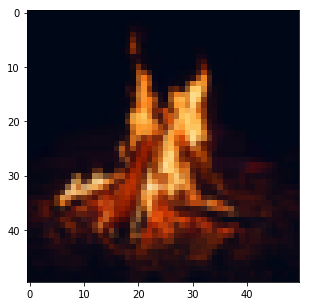

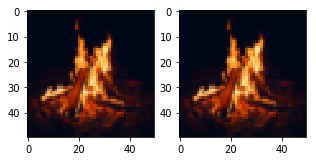

In [157]:
%matplotlib inline
# display the images
fig, ax1,  = plt.subplots(1, 1, figsize=(5, 5))
# content and style ims side-by-side
ax1.imshow(im_convert(content))

if len(styles)> 1:
    fig, axs = plt.subplots(1, len(styles), figsize= (5, 5*len(styles)))
    for ax, style in zip(axs, styles):
        ax.imshow(im_convert(style))
else:
    fig, ax = plt.subplots(1,1, figsize=(5, 5))
    ax.imshow(im_convert(styles[0]))

---
## VGG19 Layers

To get the content and style representations of an image, we have to pass an image forward throug the VGG19 network until we get to the desired layer(s) and then get the output from that layer.

In [158]:
# print out VGG16 structure so you can see the names of various layers
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

## Content and Style Features

Below, complete the mapping of layer names to the names found in the paper for the _content representation_ and the _style representation_.

In [159]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'
                 }
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

## Putting it all Together

Now that we've written functions for extracting features and computing the gram matrix of a given convolutional layer; let's put all these pieces together! We'll extract our features from our images and calculate the gram matrices for each layer in our style representation.

In [160]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features_ls = [get_features(i, vgg) for i in styles]

# calculate the gram matrices for each layer of our style representation
style_grams_ls = [{layer: gram_matrix(style_features[layer])  for style_features in style_features_ls for layer in style_features}]

# Start with copy of content image
target = content.clone().requires_grad_(True).to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


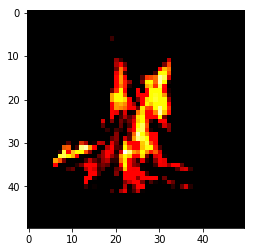

In [161]:
plt.imshow(target[0,:,:,:].detach().cpu().permute((1,2,0)))

In [162]:
# weights for each style layer
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation

style_weights_dict = {

    'High': {'conv1_1': 0.2,
             'conv2_1': 0.2,
             'conv3_1': 0.2,
             'conv4_1': 0.75,
             'conv5_1': 1},
    
    'Normal': {'conv1_1': 1.,
               'conv2_1': 0.75,
               'conv3_1': 0.2,
               'conv4_1': 0.2,
               'conv5_1': 0.2},

    'Low': {'conv1_1': 0.5,
            'conv2_1': 0.3,
            'conv3_1': 0.2,
            'conv4_1': 0.2,
            'conv5_1': 0.2},
    
        'Classic': {'conv1_1': 0.2,
            'conv2_1': 0.2,
            'conv3_1': 0.2,
            'conv4_1': 0.2,
            'conv5_1': 0.2}
}



# content_style_ratio = 1e-6  # alpha/beta ratio


# Visualize style of different style weight

In [163]:
content_features['conv1_1'][:,0,:,:].size()

torch.Size([1, 50, 50])

# New Part

In [164]:
style_levels =  ['Classic','Normal','High','Low']
style_content_ratios = [100,10000,1000000]

list(product(style_levels, style_content_ratios))

[('Classic', 100),
 ('Classic', 10000),
 ('Classic', 1000000),
 ('Normal', 100),
 ('Normal', 10000),
 ('Normal', 1000000),
 ('High', 100),
 ('High', 10000),
 ('High', 1000000),
 ('Low', 100),
 ('Low', 10000),
 ('Low', 1000000)]

run [20]:
Style Loss: 0.000000 Content Loss: 0.000000
Total Loss: 0.000000

Step 20 -------


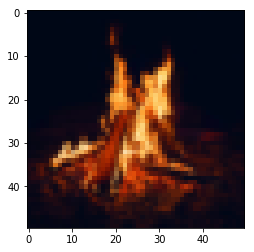

run [20]:
Style Loss: 0.000000 Content Loss: 0.000000
Total Loss: 0.000000

Step 20 -------


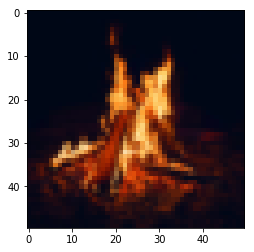

run [20]:
Style Loss: 0.000000 Content Loss: 0.000000
Total Loss: 0.000000

Step 20 -------


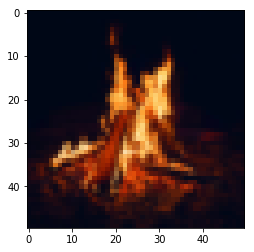

run [20]:
Style Loss: 0.000000 Content Loss: 0.000000
Total Loss: 0.000000

Step 20 -------


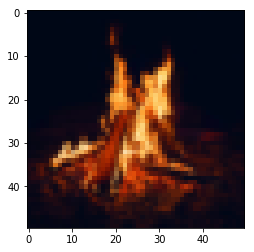

run [20]:
Style Loss: 0.000000 Content Loss: 0.000000
Total Loss: 0.000000

Step 20 -------


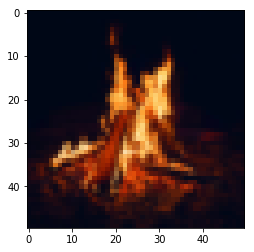

KeyboardInterrupt: 

In [165]:
for style_level, style_content_ratio in tqdm(list(product(style_levels,style_content_ratios))):
    # Start from a fresh photo
    target = content.clone().requires_grad_(True).to(device)
           
    # for displaying the target image, intermittently
    show_every = 1
    style_weights = style_weights_dict[style_level]
    # iteration hyperparameters
    optimizer = optim.LBFGS([target], lr=0.2)
    steps = 20  # decide how many iterations to update your image (5000)
    run = [0]

    OUTPUT = Path('output')
    output_dir = f"{content_fn}_{'_'.join([fn for fn in style_fns])}"
    OUTPUT = OUTPUT/output_dir
    OUTPUT.mkdir(exist_ok=True)
    OUTPUT_SUBPATH = OUTPUT/f"{style_level}_{style_content_ratio}"
    OUTPUT_SUBPATH.mkdir(exist_ok=True)

    for ii in tqdm(range(1, steps+1)):

        def closure():
            # get the features from your target image
            target_features = get_features(target, vgg)

            # the content loss
            content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

            # initialize the style loss to 0
            style_loss = 0
            # then add to it for each layer's gram matrix loss
            for layer in style_weights:
                # get the "target" style representation for the layer
                target_feature = target_features[layer]
                target_gram = gram_matrix(target_feature)
                _, d, h, w = target_feature.shape
                for style_grams in style_grams_ls:
                    # get the "style" style representation
                    style_gram = style_grams[layer]
                    # the style loss for one layer, weighted appropriately
                    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
                    # add to the style loss
                    style_loss += layer_style_loss / (d * h * w)

            # calculate the *total* loss
            style_loss =  style_loss * style_content_ratio            
            total_loss =  content_loss  + style_loss

            # update your target image
            optimizer.zero_grad()
            total_loss.backward()

            run[0] += 1
            if run[0] % 20 == 0:
                print("run {}:".format(run))
                print('Style Loss: {:4f}'.format(style_loss), 'Content Loss: {:4f}'.format(content_loss))
                print('Total Loss: {:4f}'.format(total_loss))
                print()
                print(f'Step {ii} -------')
            return total_loss
        
        # Save the first image
        plt.imsave(OUTPUT_SUBPATH/f"{ii}.jpg",im_convert(target))
        optimizer.step(closure)
              
    # Finish 1 set of parameter                  
    images = []
    for filename in OUTPUT_SUBPATH.glob('*.jpg'):
         images.append(imageio.imread(filename))
    
    imageio.mimsave(OUTPUT/f"{output_dir}_{style_level}_{style_content_ratio}.gif", images, fps=4) # Output gif
    plt.imsave(OUTPUT/f"{output_dir}_{style_level}_{style_level}_{style_content_ratio}.jpg",im_convert(target)) # Output the last image as well
    plt.imshow(im_convert(target))
    plt.show()


## Display the Target Image

In [ ]:
h,w = len(style_content_ratios), len(style_levels)
fig, axs = plt.subplots(h, w, figsize = (16,12), sharex=True, sharey=True)
plt.tight_layout()

imgs = []
styles = []
ratios = []
for file in OUTPUT.glob('*.jpg'):
    img = plt.imread(file)
    imgs.append(img)
    styles.append(file.parts[-1].split('_')[-2])
    ratios.append(file.parts[-1].split('_')[-1].split('.jpg')[0])

for i,ax in enumerate(axs):  
    for j, axe  in enumerate(ax):
        if i==0:
            axe.set_title(ratios[j*len(style_content_ratios) + i])
        if j==0:
            axe.set_ylabel(styles[j*len(style_content_ratios) + i])
        axe.imshow(imgs[j*len(style_content_ratios) + i])
    
plt.show()

In [ ]:
fig.savefig(f"{output_dir}.jpg")